<a href="https://colab.research.google.com/github/NRiccieri/HIAAC_Project_Group3/blob/main/FL_proposta_algoritmo_compressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **FL Compression Algorithm**

**Experiment parameters**

In [1]:
#FL environment parameters

num_clients = 35   #total number of devices in the FL environment
percentage_clients_considered = .4    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = int(num_clients*percentage_clients_considered)
num_clients_selected = int(percentage_clients_selected*num_clients_considered)


#training parameters
num_iterations_per_round = 10 #number of iterations executed by clients at each round of the algorithm

max_num_rounds = 200

validation_size = 0.15

epsilon = 0.0 #difference between the trained FL global model accuracy score and the centralised model accuracy score

accuracy_score_target = 0.9

Note: In the centralized training, given the architecture used (3 hidden layers with 256 units), we reach an accuracy score of about 98.5% in 120 epochs on the training set. **The accuracy score on the testing data is around 91%.** The training time is 2 minutes 22 seconds.

**In the Federated Learning environment, the goal is for the global model located in the central server to be as close as possible to an accuracy score of 91% on the test data.**


## **Importing the dataset from Kaggle**

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
#create gdrive folder inside content
from google.colab import drive
drive.mount('/content/gdrive')

#importing dataset to google colab from gdrive
!cp /content/gdrive/MyDrive/kaggle_datasets/archive.zip  /content/archive.zip 

#unzipping 
!unzip archive.zip 

Mounted at /content/gdrive
Archive:  archive.zip
  inflating: test.csv                
  inflating: train.csv               


In [4]:
#train dataset that will be split between all clients
df_train = pd.read_csv('train.csv')

x_train = pd.DataFrame(df_train.drop(['Activity','subject'],axis=1))
y_train = df_train.Activity.values.astype(object)

#test dataset that will be located in central server
df_test = pd.read_csv('test.csv')

central_server_data_x = pd.DataFrame(df_test.drop(['Activity','subject'],axis=1))
central_server_data_y_true = df_test.Activity.values.astype(object)

In [5]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

encoder=preprocessing.LabelEncoder()

encoder.fit(y_train)
y_train = encoder.transform(y_train)
print(encoder.classes_)

scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)

#scaling central server dataset
central_server_data_x = scaler.transform(central_server_data_x)
central_server_data_y_true = encoder.transform(central_server_data_y_true)

#creating the datasets
#x_test/y_test could be used by server to check gloabl model accuracy
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, random_state=100)

['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


## **Creating datasets for each client**

In [6]:
#returns an object with clientID as key, and its dataset
def returnDatasetPerClientObject(x, y):
  datasetObject = []

  n = x.shape[0]
  m = int(n/num_clients)

  i = 0
  while i < num_clients:
    client_i_x = x[ m * i :  m * (i + 1) ]
    client_i_y = y[ m * i :  m * (i + 1) ]
    datasetObject.append({"x": client_i_x, "y": client_i_y})
    i +=1

  return datasetObject


#returns the dataset x/y of a client
def returnDatasetForClient(clientid, datasetObject):
  return {"x" : datasetObject[clientid]["x"] , "y" : datasetObject[clientid]["y"]}


## **Dataset distribution analysis**

In [9]:
import numpy as np
from scipy.stats import kruskal

clients_dataset = returnDatasetPerClientObject(x_train, y_train)

clientIDs_list = [0, 1, 2, 3]
client_y_list = []

for client_id in clientIDs_list:
  client_data = returnDatasetForClient(client_id, clients_dataset)
  client_y_list.append(client_data["y"])


kruksal_test = kruskal(client_y_list[0],client_y_list[1],client_y_list[2],client_y_list[3])
print("Test statistic: Chi^2 = ", kruksal_test.statistic, ", p =", kruksal_test.pvalue)

Test statistic: Chi^2 =  17.989495330776183 , p = 0.0004420493148934156


## **Machine learning model implementation**

**In TensorFlow**

**Functions in central server side**

In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt


def returnInitialGlobalModel():

  model = Sequential([
      
      # reshape 28 row * 28 column data to 28*28 rows
      Flatten(input_shape=(561,), name="inputlayer"),
      
      # dense layer 1
      Dense(256, activation='sigmoid', name="firstlayer"),  
      
      # dense layer 2
      Dense(256, activation='sigmoid', name="secondlayer"), 

      # dense layer 3
      Dense(256, activation='sigmoid', name="thirdlayer"), 
      
      # output layer
      Dense(6, activation='sigmoid', name="outputlayer"),  
  ])

  model.compile(optimizer='sgd',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
  
  return model


#returns a copy of the global model to client
def returnCopyGlobalModelToClient(globalmodel):

  clientmodel = returnInitialGlobalModel()
  clientmodel.set_weights(globalmodel.get_weights()) 

  return clientmodel


#function that returns the accuracy score of the global model on the client's data
def evaluateGlobalModel(globalmodel, x, y):
  
  results = globalmodel.evaluate(x, y, verbose=0)

  return results[1]


#function that uncompresses the gradient from the clients
def uncompressClientsGradient(clientscompressedgradientobject):

  clientsUncompressedradientobject = clientscompressedgradientobject
  
  return clientsUncompressedradientobject

#add the client gradient to the global model
def addGradient(modelNotTrained, gradient):
  newWeight = []
  i = 0
  notTrainedWeight = modelNotTrained.get_weights()
  for weight in modelNotTrained.get_weights():
    newWeight.append( weight - (gradient[i] / num_clients_selected) )
    i += 1
  modelNotTrained.set_weights(newWeight)


# #update the central server model with the gradient from clients
# def updateGlobalModelWeights(globalmodel, clientsgradientobject):

#   for clientgradient in clientsgradientobject:
#     i = 0
#     for layer in globalmodel.layers:
#       if i >= 1:
#         j = 0
#         for weight in layer.weights:
#           current_weights = layer.weights[j]
#           globalmodel.layers[i].weights[j] = current_weights - clientgradient["clientgradient"].layers[i].weights[j] / num_clients_selected
#           j += 1
#       i +=1

**Functions in clients side**

In [8]:
#returns the compressed gradient to be sent to central server
def compressGradient(clientgradient):
  
  compressedclientgradient = clientgradient
  return compressedclientgradient

#Given the weights after training and initial weights, returns the gradient from entire training
def computeClientGradient(modelNotTrained, modelTrained):
  gradient = []
  notTrainedWeight = modelNotTrained.get_weights()
  i = 0
  for weight in modelTrained.get_weights():
    gradient.append( notTrainedWeight[i] - weight )
    i += 1
  return gradient

## **Central server logic implementation**

In [9]:
import random


#Generate a random list of clients considered of length num_clients_considered
def returnRandomSelectedClientsIDsList():
  return random.sample(range(0, num_clients), num_clients_considered)


#function that returns the evaluation of the global model on the selected clients
def returnWorstLossesAmongChosenClients(classifierModel, chosenClients, datasetObject):
  
  clients_accuracy_list = [] #modelEvaluationObject()
  j = 0 
  
  #evaluate the classifier on each random client's data
  while j < len(chosenClients):
    
    client_id = chosenClients[j]
    client_dataset = returnDatasetForClient(client_id, datasetObject)
    client_accuracy_score = evaluateGlobalModel(classifierModel, client_dataset["x"], client_dataset["y"])
    
    clients_accuracy_list.append({"clientID": client_id, "accuracy": client_accuracy_score})

    j+= 1

  #order the losses from worst to best
  clients_accuracy_list.sort(key=lambda x: x["accuracy"], reverse=False)

  return clients_accuracy_list



#main code running on server side
def runTraining(classifierModel, accuracyScoreTarget, clientsDatasetObject):

  #We first evaluate the global model
  globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)
  
  print("Starting")
  print("Before training global model accuracy =", globalAccuracy)
  print()

  i = 0
  accuracy_score = 0
  per_round_global_model_accuracy = []
  convergence_reached_at_round = 0
  
  randomly_considered_clients_per_round_list = [] #saving the clients considered on each round to repeat the experiment 

  while i < max_num_rounds:

      #print("Round ", i + 1, " / Max rounds ", max_num_rounds)
      
      #select random clients
      random_clients = returnRandomSelectedClientsIDsList()

      #return the list of clients with loss value from worst to best
      pretraining_loss_values_obj = returnWorstLossesAmongChosenClients(classifierModel, random_clients, clientsDatasetObject)

      #save the clients randomly selected to repeat the experiment with lesser clients selected
      randomly_considered_clients_per_round_list.append(pretraining_loss_values_obj)

      #print("Model evaluation on clients : ", pretraining_loss_values_obj)
      #print("Selected clients :", pretraining_loss_values_obj[:num_clients_selected])

      selected_clients_grad_list = []
      
      ##################
      #At client
      ##################

      #training classifier on each client
      for selected_client in pretraining_loss_values_obj[:num_clients_selected]:
        
        client_id = selected_client["clientID"]
        
        #making a copy of the classifier from central server
        client_model = returnCopyGlobalModelToClient(classifierModel)
        
        #training the global model on client's local data
        client_data = returnDatasetForClient(client_id, clientsDatasetObject)
        client_model.fit(client_data["x"], client_data["y"], epochs = num_iterations_per_round, 
          validation_split = validation_size, verbose=0)

        #getting the gradient from the client
        client_gradient = computeClientGradient(classifierModel, client_model)
        
        #should compress the gradient before sending the client's gradient to central server
        compressed_client_gradient = compressGradient(client_gradient)

        #storing the gradients to be sent to central server
        selected_clients_grad_list.append( {"clientID": client_id, "clientgradient": compressed_client_gradient} )



      ##################
      #At central server
      ##################

      #uncompress the gradient from clients
      selected_clients_grad_list = uncompressClientsGradient(selected_clients_grad_list)

      #updating the global model weights
      for client_gradient in selected_clients_grad_list:
        addGradient(classifierModel, client_gradient["clientgradient"])

      #evaluating the global model on data contained in central server
      globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)

      per_round_global_model_accuracy.append(globalAccuracy)

      #print("Current global model accuracy score = ", globalAccuracy)
      #print()  

      if globalAccuracy >= accuracyScoreTarget - epsilon and convergence_reached_at_round == 0:
        print("")
        print("Global model converged")
        print("Convergence accuracy score = ", globalAccuracy)
        convergence_reached_at_round = i

      i += 1

  #plot the results 
  print("Number of clients :", num_clients)
  print("Number of clients participating per round :", num_clients_considered)
  print("Number of clients training the model per round : ", num_clients_selected)
  print("Number of iterations per client per round : ", num_iterations_per_round)
  #print("Number of rounds until convergence : ", i)

  plt.plot(per_round_global_model_accuracy)
  plt.ylabel('Accuracy per round')
  plt.show()


  return [classifierModel, per_round_global_model_accuracy, i, randomly_considered_clients_per_round_list]


In [10]:

#main code running on server side
def repeatExperiment(classifierModel, accuracyScoreTarget, clientsDatasetObject, clientsConsideredHistory):

  #We first evaluate the global model
  globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)
  
  print("Starting")
  print("Before training global model accuracy =", globalAccuracy)
  print()

  i = 0
  accuracy_score = 0
  per_round_global_model_accuracy = []
  convergence_reached_at_round = 0
  
  while i < max_num_rounds:

      #print("Model evaluation on clients : ", pretraining_loss_values_obj)
      #print("Selected clients :", pretraining_loss_values_obj[:num_clients_selected])

      selected_clients_grad_list = []
      
      pretraining_loss_values_obj = clientsConsideredHistory[i]

      ##################
      #At client
      ##################

      #training classifier on each client
      for selected_client in pretraining_loss_values_obj[:num_clients_selected]:
        
        client_id = selected_client["clientID"]
        
        #making a copy of the classifier from central server
        client_model = returnCopyGlobalModelToClient(classifierModel)
        
        #training the global model on client's local data
        client_data = returnDatasetForClient(client_id, clientsDatasetObject)
        client_model.fit(client_data["x"], client_data["y"], epochs = num_iterations_per_round, 
          validation_split = validation_size, verbose=0)

        #getting the gradient from the client
        client_gradient = computeClientGradient(classifierModel, client_model)
        
        #should compress the gradient before sending the client's gradient to central server
        compressed_client_gradient = compressGradient(client_gradient)

        #storing the gradients to be sent to central server
        selected_clients_grad_list.append( {"clientID": client_id, "clientgradient": compressed_client_gradient} )



      ##################
      #At central server
      ##################

      #uncompress the gradient from clients
      selected_clients_grad_list = uncompressClientsGradient(selected_clients_grad_list)

      #updating the global model weights
      for client_gradient in selected_clients_grad_list:
        addGradient(classifierModel, client_gradient["clientgradient"])

      #evaluating the global model on data contained in central server
      globalAccuracy = evaluateGlobalModel(classifierModel, central_server_data_x, central_server_data_y_true)

      per_round_global_model_accuracy.append(globalAccuracy)

      #print("Current global model accuracy score = ", globalAccuracy)
      #print()  

      if globalAccuracy >= accuracyScoreTarget - epsilon and convergence_reached_at_round == 0:
        print("")
        print("Global model converged")
        print("Convergence accuracy score = ", globalAccuracy)
        convergence_reached_at_round = i
        #break

      i += 1

  #plot the results 
  print("Number of clients :", num_clients)
  print("Number of clients participating per round :", num_clients_considered)
  print("Number of clients training the model per round : ", num_clients_selected)
  print("Number of iterations per client per round : ", num_iterations_per_round)
  #print("Number of rounds until convergence : ", i)

  plt.plot(per_round_global_model_accuracy)
  plt.ylabel('Accuracy per round')
  plt.show()


  return [classifierModel, per_round_global_model_accuracy, i]

## **Experiments**

### **Power-Of-Choice Selection**

Among all participating clients, we select only a portion of the clients with the worst accuracy score for training the global model

**15 participating clients and 10 selected clients**

Starting
Before training global model accuracy = 0.16661010682582855


Global model converged
Convergence accuracy score =  0.900237500667572
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  10
Number of iterations per client per round :  10


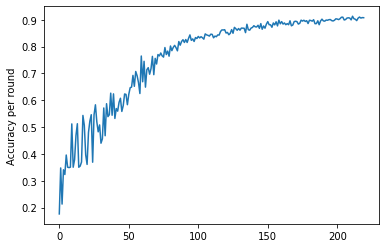

In [11]:
#FL environment parameters
percentage_clients_considered = .3    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 10 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 220

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc, num_rounds, clients_considered_history = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

**15 participating clients and 8 selected clients for training**

Starting
Before training global model accuracy = 0.15982355177402496


Global model converged
Convergence accuracy score =  0.9060060977935791
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  8
Number of iterations per client per round :  10


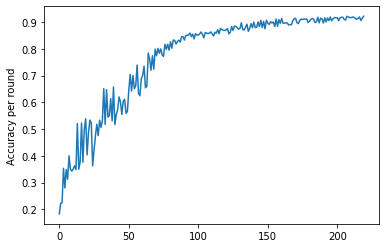

In [12]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 8 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_8, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


**15 participating clients and 6 selected clients**

Starting
Before training global model accuracy = 0.1425178200006485


Global model converged
Convergence accuracy score =  0.9015948176383972
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  6
Number of iterations per client per round :  10


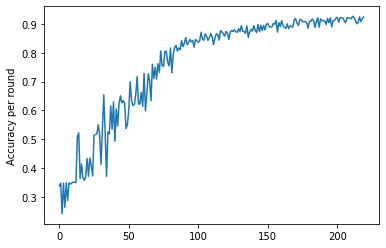

In [13]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 6 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_6, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


**15 participating and 4 selected clients**

Starting
Before training global model accuracy = 0.16661010682582855


Global model converged
Convergence accuracy score =  0.900237500667572
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  4
Number of iterations per client per round :  10


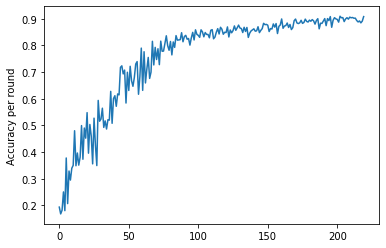

In [14]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 4 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_4, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


Starting
Before training global model accuracy = 0.1425178200006485


Global model converged
Convergence accuracy score =  0.9012554883956909
Number of clients : 35
Number of clients participating per round : 15
Number of clients training the model per round :  15
Number of iterations per client per round :  10


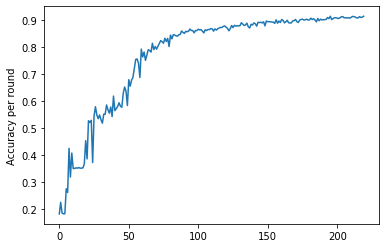

In [16]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 15 #int(num_clients*percentage_clients_considered)
num_clients_selected = 15 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_15_15, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history)


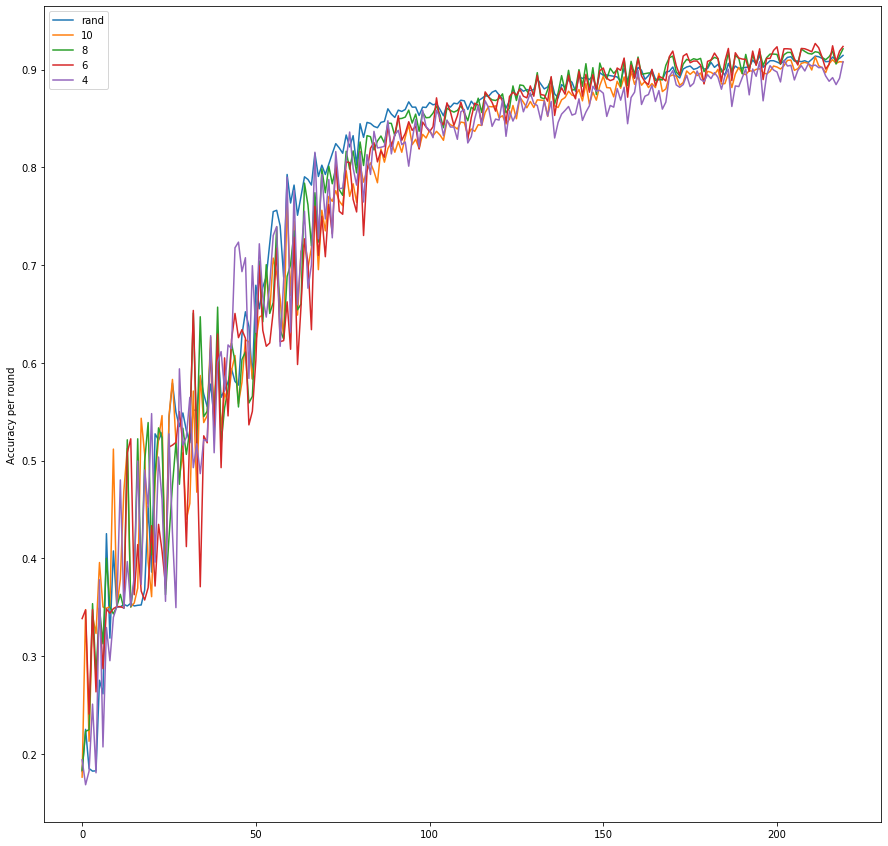

In [24]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_15_15)
plt.plot(accuracy_history_poc)
plt.plot(accuracy_history_poc_15_8)
plt.plot(accuracy_history_poc_15_6)
plt.plot(accuracy_history_poc_15_4)
plt.ylabel('Accuracy per round')
plt.legend(["rand","10", "8", "6", "4"])

plt.show()

In [18]:
print(accuracy_history_poc)
print(accuracy_history_poc_15_15)
print(accuracy_history_poc_15_8)
print(accuracy_history_poc_15_6)
print(accuracy_history_poc_15_4)

[0.17611129581928253, 0.34747201204299927, 0.21275873482227325, 0.3406854569911957, 0.3230403661727905, 0.3956565856933594, 0.35018661618232727, 0.34882932901382446, 0.35052594542503357, 0.5117068290710449, 0.35018661618232727, 0.3783508539199829, 0.4682728052139282, 0.5123854875564575, 0.35018661618232727, 0.35425856709480286, 0.36952832341194153, 0.5432643294334412, 0.5066168904304504, 0.396335244178772, 0.36070579290390015, 0.47980996966362, 0.5222259759902954, 0.5459789633750916, 0.36884966492652893, 0.545300304889679, 0.5829657316207886, 0.519511342048645, 0.4821852743625641, 0.5079742074012756, 0.43976926803588867, 0.45605701208114624, 0.5710892677307129, 0.467594176530838, 0.5870376825332642, 0.5388530492782593, 0.5459789633750916, 0.6263997554779053, 0.5439429879188538, 0.6236851215362549, 0.5320665240287781, 0.5690532922744751, 0.5592127442359924, 0.5921275615692139, 0.6073973774909973, 0.5581947565078735, 0.5799117684364319, 0.6233457922935486, 0.6216491460800171, 0.583305060

**10 participating clients**

Starting
Before training global model accuracy = 0.16830675303936005


Global model converged
Convergence accuracy score =  0.9015948176383972
Number of clients : 35
Number of clients participating per round : 10
Number of clients training the model per round :  10
Number of iterations per client per round :  10


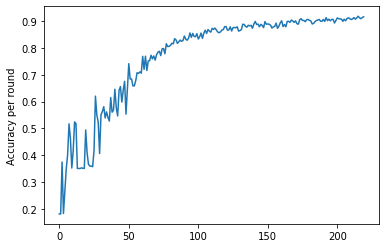

In [28]:
#FL environment parameters
percentage_clients_considered = .3    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 10 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 220

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_10, num_rounds, clients_considered_history_10_8 = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

10 clients considered and 8 selected

Starting
Before training global model accuracy = 0.18052256107330322


Global model converged
Convergence accuracy score =  0.9012554883956909
Number of clients : 35
Number of clients participating per round : 10
Number of clients training the model per round :  8
Number of iterations per client per round :  10


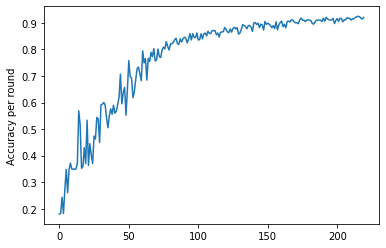

In [29]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 8 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_8, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history_10_8)


**10 participating clients and 6 selected**

Starting
Before training global model accuracy = 0.18052256107330322


Global model converged
Convergence accuracy score =  0.9060060977935791
Number of clients : 35
Number of clients participating per round : 10
Number of clients training the model per round :  6
Number of iterations per client per round :  10


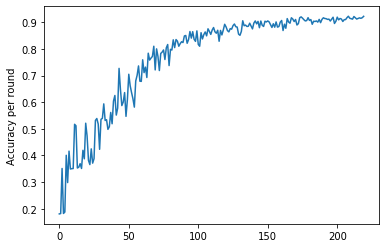

In [30]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 6 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_6, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history_10_8)


10 participating clients and 4 selected

Starting
Before training global model accuracy = 0.16830675303936005


Global model converged
Convergence accuracy score =  0.9015948176383972
Number of clients : 35
Number of clients participating per round : 10
Number of clients training the model per round :  4
Number of iterations per client per round :  10


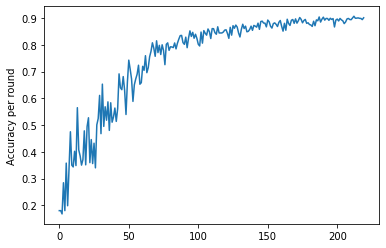

In [31]:
#FL environment parameters
percentage_clients_considered = .2    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

#num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 4 #int(percentage_clients_selected*num_clients_considered)

#max_num_rounds = 350

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_10_4, num_rounds = repeatExperiment(initial_global_model, accuracy_score_target , clients_dataset, clients_considered_history_10_8)


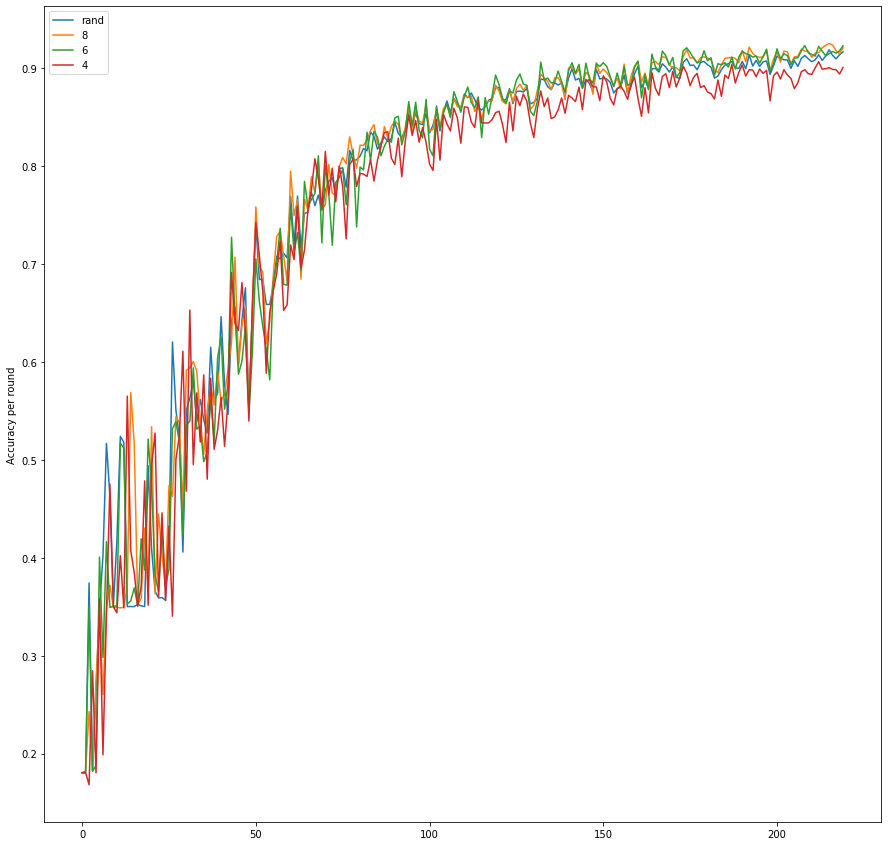

In [32]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_10_10)
plt.plot(accuracy_history_poc_10_8)
plt.plot(accuracy_history_poc_10_6)
plt.plot(accuracy_history_poc_10_4)
plt.ylabel('Accuracy per round')
plt.legend(["rand", "8", "6", "4"])

plt.show()

In [33]:
print(accuracy_history_poc_10_10)
print(accuracy_history_poc_10_8)
print(accuracy_history_poc_10_6)
print(accuracy_history_poc_10_4)

[0.18052256107330322, 0.18052256107330322, 0.3742789328098297, 0.18221920728683472, 0.26501527428627014, 0.34848999977111816, 0.40210384130477905, 0.5167967677116394, 0.46284356713294983, 0.35188326239585876, 0.4166949391365051, 0.5239226222038269, 0.5178147554397583, 0.35018661618232727, 0.35018661618232727, 0.35018661618232727, 0.35256192088127136, 0.35086527466773987, 0.35018661618232727, 0.49406176805496216, 0.40889039635658264, 0.36579573154449463, 0.35900917649269104, 0.35934847593307495, 0.35663387179374695, 0.417712926864624, 0.6202918291091919, 0.5503902435302734, 0.5232439637184143, 0.40583643317222595, 0.5507295727729797, 0.5629453659057617, 0.5809297561645508, 0.5388530492782593, 0.5615880489349365, 0.5412283539772034, 0.5273159146308899, 0.6148625612258911, 0.5602307319641113, 0.5680353045463562, 0.646080732345581, 0.5771971344947815, 0.5463182926177979, 0.6420088410377502, 0.6559212803840637, 0.5982354879379272, 0.6426874995231628, 0.6756023168563843, 0.5531048774719238, 

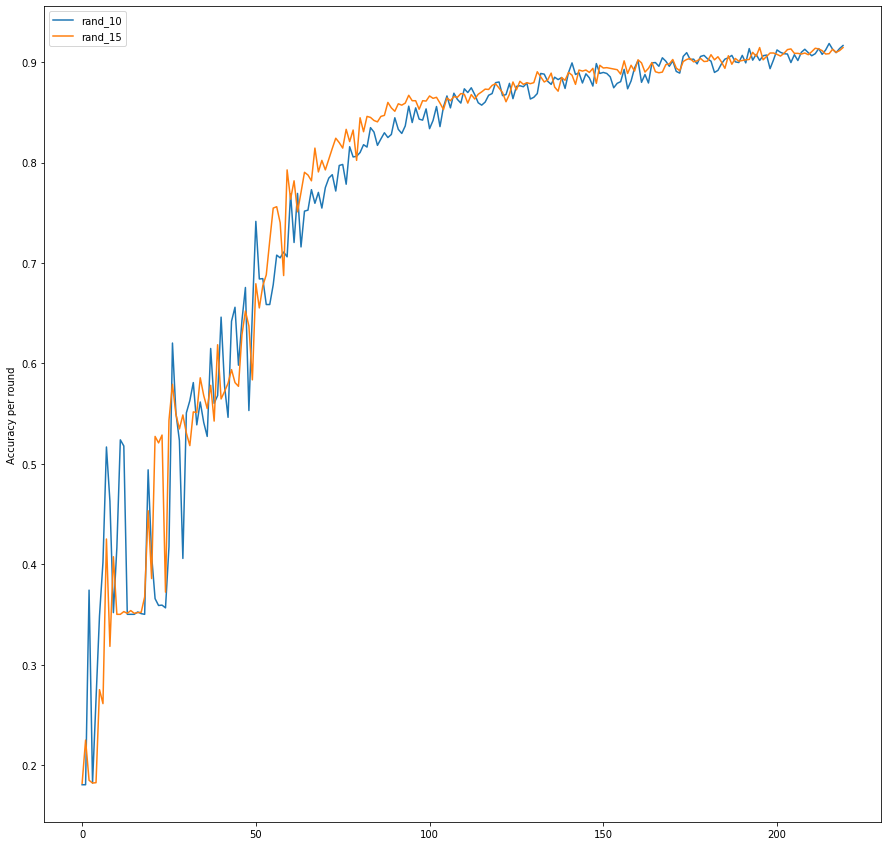

In [34]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_10_10)
plt.plot(accuracy_history_poc_15_15)
plt.ylabel('Accuracy per round')
plt.legend(["rand_10", "rand_15"])

plt.show()

Starting
Before training global model accuracy = 0.21174074709415436


Global model converged
Convergence accuracy score =  0.9056667685508728
Number of clients : 35
Number of clients participating per round : 5
Number of clients training the model per round :  5
Number of iterations per client per round :  10


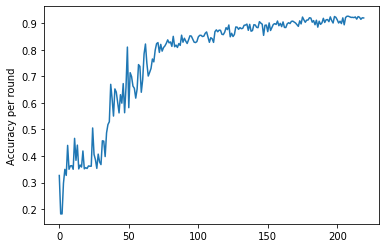

In [35]:
#FL environment parameters
percentage_clients_considered = .3    #percentage of clients randomly selected by central server
percentage_clients_selected = .5    #percentage of clients selected among the clients considered

num_clients_considered = 5 #int(num_clients*percentage_clients_considered)
num_clients_selected = 5 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 220

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

initial_global_model = returnInitialGlobalModel()
final_global_model, accuracy_history_poc_5_5, num_rounds, clients_considered_history_5_5 = runTraining(initial_global_model, accuracy_score_target , clients_dataset)

In [36]:
accuracy_history_poc_5_5

[0.3267729878425598,
 0.18221920728683472,
 0.18221920728683472,
 0.2975907623767853,
 0.34984731674194336,
 0.3271123170852661,
 0.44010859727859497,
 0.35018661618232727,
 0.36308109760284424,
 0.36375975608825684,
 0.35018661618232727,
 0.4665761888027191,
 0.3837801218032837,
 0.4411265552043915,
 0.35154393315315247,
 0.3661350607872009,
 0.35866984724998474,
 0.4190702438354492,
 0.35188326239585876,
 0.35629454255104065,
 0.35324057936668396,
 0.36274176836013794,
 0.36172378063201904,
 0.36172378063201904,
 0.5055989027023315,
 0.40617576241493225,
 0.3861554265022278,
 0.35357990860939026,
 0.40719375014305115,
 0.3780115246772766,
 0.3678317070007324,
 0.45741432905197144,
 0.45605701208114624,
 0.39803189039230347,
 0.4869358539581299,
 0.5184933543205261,
 0.5290125608444214,
 0.6698337197303772,
 0.6155412197113037,
 0.5503902435302734,
 0.6525279879570007,
 0.640651524066925,
 0.6016287803649902,
 0.5622667074203491,
 0.6308109760284424,
 0.5989141464233398,
 0.6725483536

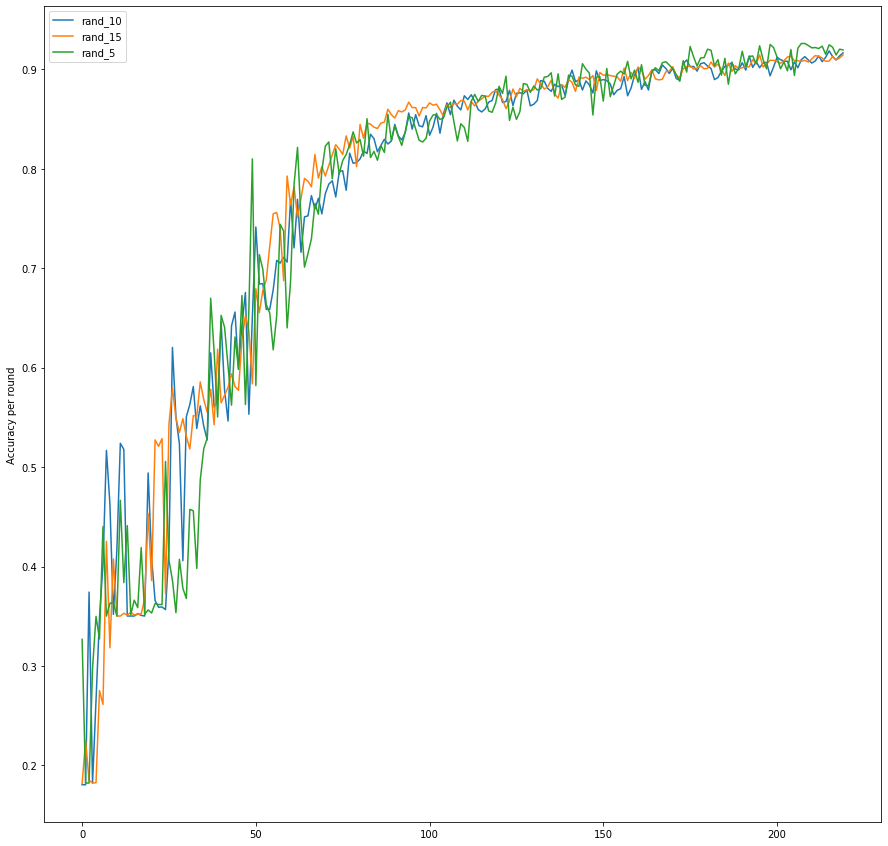

In [37]:
plt.figure(figsize=(15, 15))
plt.plot(accuracy_history_poc_10_10)
plt.plot(accuracy_history_poc_15_15)
plt.plot(accuracy_history_poc_5_5)
plt.ylabel('Accuracy per round')
plt.legend(["rand_10", "rand_15", "rand_5"])

plt.show()

### **All participating clients are training the global model**

**10 clients fully participating**

In [ ]:
#FL environment parameters
percentage_clients_considered = .3    #percentage of clients randomly selected by central server
percentage_clients_selected = 1.0    #percentage of clients selected among the clients considered

num_clients_considered = 10 #int(num_clients*percentage_clients_considered)
num_clients_selected = 10 #int(percentage_clients_selected*num_clients_considered)

max_num_rounds = 400

num_rounds_list = []

#splitting the dataset between all clients
clients_dataset = returnDatasetPerClientObject(x_train, y_train)

s = 0
while s < 10:
  initial_global_model = returnInitialGlobalModel()
  final_global_model, accuracy_history__all_parti_clients_training, num_rounds = runTraining(initial_global_model, accuracy_score_target , clients_dataset)
  num_rounds_list.append(num_rounds)
  
  s+= 1

print("Number of rounds till convergence : ", num_rounds_list)

### **Comparisons**

In [ ]:
plt.plot(accuracy_history_poc)
plt.plot(accuracy_history__all_parti_clients_training)
plt.ylabel('Accuracy per round')
plt.legend(["P-O-C", "All partipating clients in training"])
plt.show()